$
\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mv}{{\bf V}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\ball}{{\cal B}}
\newcommand{\ptc}{{\Psi TC}}
\newcommand{\diag}{\mbox{diag}}
$

In [1]:
using SIAMFANLEquations
using SIAMFANLEquations.TestProblems
using SIAMFANLEquations.NotebookSIAMFANL
using LinearAlgebra
using PyPlot

## Section 2.7 Solvers for Chapter 2

Contents for Section 1.10

[Overview](#Overview)

[nsolsc.jl](#nsold.jl)



### Overview

We will follow the patter of Chapter 1 and present two sovlers, a Newton code and a $\ptc$ code. Both codes are for systems of equations and use direct methods to compute the step. We returned the solution history for the simple two dimensional example in Section 2.6, but will not do that again.

### nsold.jl

__nsold.jl__ solves systems of nonlinear equations and computes the Newton step with direct linear solvers. Let's look at the docstrings.

In [2]:
?nsold

search: nsold nsolsc



```
nsold(F!, x0, FS, FPS, J!=diffjac!; rtol=1.e-6, atol=1.e-12,
           maxit=20, solver="newton", sham=1, armmax=10, resdec=.1,
           dx = 1.e-7, armfix=false, 
           pdata = nothing, jfact = klfact,
           printerr = true, keepsolhist = false, stagnationok=false)
```

)

C. T. Kelley, 2020

Julia versions of the nonlinear solvers from my SIAM books.  Herewith: nsold

You must allocate storage for the function and Jacobian in advance –> in the calling program <– ie. in FS and FPS

Inputs:

  * F!: function evaluation, the ! indicates that F! overwrites FS, your   preallocated storage for the function.

```
FV=F!(FV,x) or FV=F!(FV,x,pdata) returns FV=F(x)
```

  * x0: initial iterate

  * FS: Preallcoated storage for function. It is an N x 1 column vector

  * FPS: preallcoated storage for Jacobian. It is an N x N matrix

  * J!: Jacobian evaluation, the ! indicates that J! overwrites FPS, your   preallocated storage for the Jacobian. If you leave this out the   default is a finite difference Jacobian.

```
FP=J!(FP,FV,x) or FP=J!(FP,FV,x,pdata) returns FP=F'(x);
(FP,FV, x) must be the argument list, even if FP does not need FV.
One reason for this is that the finite-difference Jacobian
does and that is the default in the solver.

Lemme tell ya 'bout precision. I designed this code for full precision
functions and linear algebra in any precision you want. You can declare
FPS as Float64, Float32, or Float16 and nsold will do the right thing if
YOU do not destroy the declaration in your J! function. I'm amazed
that this works so easily. If the Jacobian is reasonably well 
conditioned, I can see no reason to do linear algebra in 
double precision.
```

---

Keyword Arguments (kwargs):

  * rtol and atol: relative and absolute error tolerances

  * maxit: limit on nonlinear iterations

solver: default = "newton"

Your choices are "newton" or "chord". However, you have sham at your disposal only if you chose newton. "chord" will keep using the initial derivative until the iterate converges, uses the iteration budget, or the line search fails. It is not the same as sham=Inf, which is smarter.

sham: default = 1 (ie Newton)

This is the Shamanskii method. If sham=1, you have Newton. The iteration updates the derivative every sham iterations. The convergence rate has local q-order sham+1 if you only count iterations where you update the derivative. You need not provide your own derivative function to use this option. sham=Inf is chord only if chord is converging well.

armmax: upper bound on stepsize reductions in linesearch

resdec: default = .1

This is the target value for residual reduction. The default value is .1. In the old MATLAB codes it was .5. I only turn Shamanskii on if the residuals are decreasing rapidly, at least a factor of resdec, and the line search is quiescent. If you want to eliminate resdec from the method ( you don't ) then set resdec = 1.0 and you will never hear from it again.

dx: default = 1.e-7

difference increment in finite-difference derivatives       h=dx*norm(x)+1.e-6

armfix: default = false

The default is a parabolic line search (ie false). Set to true and the stepsize will be fixed at .5. Don't do this unless you are doing experiments for research.

pdata:

precomputed data for the function/Jacobian.  Things will go better if you use this rather than hide the data  in global variables within the module for your function/Jacobian

jfact: default = klfact (tries to figure out best choice) 

If your Jacobian has any special structure, please set jfact to the correct choice for a factorization.

I use jfact when I call PrepareJac! to evaluate the Jacobian (using your J!) and factor it. The default is to use klfact (an internal function) to do something reasonable. For general matrices, klfact picks lu! to compute an LU factorization and share storage with the Jacobian.  You may change LU to something else by, for example, setting jfact = cholseky! if your Jacobian is spd.

klfact knows about banded matrices and picks qr. You should, however RTFM, allocate the extra two upper bands, and use jfact=qr! to override klfact.

If you give me something that klfact does not know how to dispatch on, then nothing happens. I just return the original Jacobian matrix and  nsold will use backslash to compute the Newton step.

I know that this is probably not optimal in your situation, so it is  good to pick something else, like jfact = lu.

Please do not mess with the line that calls PrepareJac!.          FPF = PrepareJac!(FPS, FS, x, ItRules) FPF is not the same as FPS (the storage you allocate for the Jacobian) for a reason. FPF and FPS do not have the same type, even though they share storage. So, FPS=PrepareJac!(FPS, FS, ...) will break things.

printerr: default = true

I print a helpful message when the solver fails. To supress that message set printerr to false.

keepsolhist: default = false

Set this to true to get the history of the iteration in the output tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

stagnationok: default = false

Set this to true if you want to disable the line search and either observe divergence or stagnation. This is only useful for research or writing a book.

Output:

A named tuple (solution, functionval, history, stats, idid,                errcode, solhist) where

solution = converged result functionval = F(solution) history = the vector of residual norms (||F(x)||) for the iteration stats = named tuple of the history of (ifun, ijac, iarm), the number of functions/derivatives/steplength reductions at each iteration.

I do not count the function values for a finite-difference derivative because they count toward a Jacobian evaluation. 

idid=true if the iteration succeeded and false if not.

errcode = 0 if if the iteration succeeded         = -1 if the initial iterate satisifies the termination criteria         = 10 if no convergence after maxit iterations         = 1  if the line search failed

solhist:

This is the entire history of the iteration if you've set keepsolhist=true

---

# Examples

## World's easiest problem example.

```jldoctest
 julia> function f!(fv,x)
       fv[1]=x[1] + sin(x[2])
       fv[2]=cos(x[1]+x[2])
       end
f (generic function with 1 method)

julia> x=ones(2,); fv=zeros(2,); jv=zeros(2,2);
julia> nout=nsold(f!,x,fv,jv);
julia> nout.history
5-element Array{Float64,1}:
 1.88791e+00
 2.43119e-01
 1.19231e-02
 1.03266e-05
 1.46416e-11

julia> nout.solution
2-element Array{Float64,1}:
 -7.39085e-01
  2.30988e+00

```

## H-equation example

```jldoctest
julia> n=16; x0=ones(n,); FV=ones(n,); JV=ones(n,n);
julia> hdata=heqinit(x0, .5);
julia> hout=nsold(heqf!,x0,FV,JV;pdata=hdata);
julia> hout.history
3-element Array{Float64,1}:
 6.17376e-01
 3.17810e-03
 6.22034e-08
```


#### Input

The calling sequence for the Newton solvers in this book are similar, differing mostly in the management of the linear solver and memory allocation. The calling sequence for __nsold.jl__ is

```julia
function nsold(
    F!,
    x0,
    FS,
    FPS,
    J! = diffjac!;
    rtol = 1.e-6,
    atol = 1.e-12,
    maxit = 20,
    solver = "newton",
    sham = 1,
    armmax = 10,
    resdec = 0.1,
    dx = 1.e-7,
    armfix = false,
    pdata = nothing,
    jfact = lu!,
    printerr = true,
    keepsolhist = false,
    stagnationok = false,
)
```

As we said earlier in the chapter, the calling sequence has some new things which are not in __nsolsc.jl__. The most significant are the arrays __FS__ and __FPS__, which preallocate
storage for the function and Jacobian. As we have pointed out earlier, the farther upstream one allocates memory the better, so __nsold.jl__ insists that you allocate an vector __FS__ of the same size as the initial iterate and a matrix 
__FPS__ for the Jacobian. 

The other major new feature is the keyword argument __pdata__. This is the data structure for you to store any precomuted or preallocated data your function evaluation needs. You will almost surely need __pdata__ for any but the most trivial problems. The H-equation example from section 2.6 uses __pdata__ in a serious manner.

You may dimension __x0__ either as $(N,1)$ or $(N,)$, but you must be consistent and dimension __FS__ the same way. __nsold.jl__ expects vectors to be in double precision (Float64). 

The __!__ in the function evaluation __F!__ is to indicate that __nsold__ expects __F__  to overwrite its imput. So,
the way to call __F!__ is to preallocate the storage for the function value in an array __FS__ and then call the function as
```Julia
F!(FS,x)
```
or
```Julia
F!(FS,x,pdata)
```
__nsold.jl__ will figure out if you have populated __pdata__ or left it alone as the default value of __nothing__.


And now for the Jacobian. __nsold.jl__ uses direct methods for linear algebra. If your matrix is dense, the default is to use Julia's __lu!__ function to do an LU factorization. If your matrix is symmetric or symmetric positive definite you can use the __factorization__ keyword to change __lu!__ to __ldlt!__ or __cholesky!__ for example. __nsold.jl__ assumes that the factorization you ask for will overwrite the matrix. Hence, the __factorize__ function in Julia is not what you want for this application.

You will also need to preallocate storage for the Jacobian in the array __FPS__. You may use any legal real precision for __FPS__. Float64 is the default. If you use Float32 you cut the storage for the matrix and the time for the factorization in half. We recommend that you do this if your Jacobian is dense. If you are using the __Sparsesuite__ sparse solvers, then you must store the Jacobian in double precision. __Sparsesuite__ does not support lower precision.

Your Jacobian computation __J!__ must also overwrite it's input. The call looks like
```julia
J!(FV,FP,x)
```
or 
```julia
J!(FV,FP,x,pdata)

```
returns FP=F'(x). The input FP=F(x), which __nsold.jl__ has already compouted, has to be there.


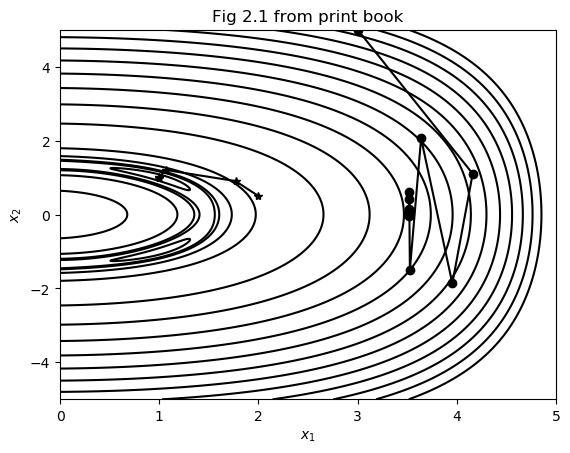

The line search failed at iteration 15
Termination with failure
Current values: maxit  =  20, armmax = 10
Give the history array a look to see what's happening.
  


In [3]:
fig2dot1();


In [4]:
fig2dot2();


LoadError: UndefVarError: fig2dot2 not defined

In [5]:
fig2dot3();

LoadError: UndefVarError: fig2dot3 not defined